In [5]:
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns

# Imports

## Librairies

In [43]:
import numpy as np
import pandas as pd
import os
import warnings
import time
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import shap

import mlflow
import mlflow.sklearn
import lightgbm as lgbm

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif

## Options

In [7]:
sns.set()
warnings.filterwarnings('ignore')

# pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
pd.set_option('display.max_colwidth', None)

logging.getLogger("mlflow").setLevel(logging.ERROR)

## Data

In [8]:
df = pd.read_csv('../data/cleaned/df.csv', sep=";")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,False,True,False,True,False,False
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,True,False,False,False,False,False,False,True,False,False
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,False,False,False,False
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,False,False,False,False
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,False,False,False,False


In [9]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 244 columns):
 #    Column                                             Non-Null Count   Dtype  
---   ------                                             --------------   -----  
 0    SK_ID_CURR                                         307511 non-null  int64  
 1    TARGET                                             307511 non-null  int64  
 2    NAME_CONTRACT_TYPE                                 307511 non-null  int64  
 3    FLAG_OWN_CAR                                       307511 non-null  int64  
 4    FLAG_OWN_REALTY                                    307511 non-null  int64  
 5    CNT_CHILDREN                                       307511 non-null  int64  
 6    AMT_INCOME_TOTAL                                   307511 non-null  float64
 7    AMT_CREDIT                                         307511 non-null  float64
 8    AMT_ANNUITY                                        307499 non-

# MLFlow

## Régression Logistique

### Préparation des données

In [10]:
if 'TARGET' in df.columns:
    X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
    y = df['TARGET']
else:
    X = df.drop(columns=['SK_ID_CURR']).copy()

feature_names = X.columns
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0, 1))

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)
print(f"Shape du dataset prétraité : {X_scaled.shape}")

Shape du dataset prétraité : (307511, 242)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape : {X_train.shape}")
print(f"Test shape : {X_test.shape}")

Train shape : (246008, 242)
Test shape : (61503, 242)


### Baseline

In [12]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Regression Logistique Baseline")

with mlflow.start_run(run_name="RL Baseline") as run:
    # Paramètres du modèle
    C_value = 0.0001

    # Entraînement du modèle
    log_reg = LogisticRegression(C=C_value, class_weight="balanced")
    log_reg.fit(X_train, y_train)

    # PRédictions
    preds = log_reg.predict(X_test)

    # Calcul des métriques
    acc = accuracy_score(y_test, preds)
    try:
        auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
    except Exception as e:
        auc = None

    print(f"Accuracy : {acc}")
    print(f"ROC AUC : {auc}")

    # Enregistrement des paramètres et métriques dans MLFlow
    mlflow.log_param("C", C_value)
    mlflow.log_param("imputer_strategy", "median")
    mlflow.log_param("scaler_range", (0, 1))
    mlflow.log_metric("accuracy", acc)

    if auc is not None:
        mlflow.log_metric("roc_auc", auc)

    # Enregistrement du modèle dans MLFlow
    mlflow.sklearn.log_model(log_reg, "model", input_example=X_test[0:1])

Accuracy : 0.6517893436092548
ROC AUC : 0.7139741749500028


## Fonction de coût

In [13]:
def custom_cost_function(y_true, y_pred, cost_false_positive=1, cost_false_negative=3):
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_pred).ravel()
    cost = cost_false_positive * false_positive + cost_false_negative * false_negative
    return cost

In [14]:
cost_scorer = make_scorer(
    custom_cost_function,
    greater_is_better=False,
    cost_false_positive = 1,
    cost_false_negative = 10
)

### Hyperparmètres

In [15]:
param_grid = {
    "C" : [0.0001, 0.001, 0.1, 1, 10]
}

log_reg = LogisticRegression(class_weight="balanced")

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=cost_scorer,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Coût minimum obtenu : {grid_search.best_score_}")

Meilleurs hyperparamètres : {'C': 10}
Coût minimum obtenu : -27110.6


In [16]:
best_cost = -grid_search.best_score_
print("Coût minimum réel :", best_cost)

Coût minimum réel : 27110.6


### Modèle avec fonction coût

In [17]:
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.set_experiment("Regression_Logistique_Score_Metier")

# with mlflow.start_run():
#     # Paramètres du modèle
#     grid_search.fit(X_train, y_train)

#     # Récupérer les résultats
#     best_cost_cv = -grid_search.best_score_
#     best_params = grid_search.best_params_
#     best_model = grid_search.best_estimator_
    
#     # Évalutation sur test
#     y_pred_test = best_model.predict(X_test)
#     true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_test, y_pred_test).ravel()
#     test_cost = 1 * false_positive + 3 * false_negative

#     # Calcul des métriques
#     acc_test = accuracy_score(y_test, y_pred_test)
#     auc_test = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

#     # Enregistrement des paramètres et métriques dans MLFlow
#     mlflow.log_params(best_params)
#     mlflow.log_param("cost_cv", best_cost_cv)
#     mlflow.log_param("cost_test", test_cost)
#     mlflow.log_param("accuracy_test", acc_test)
#     mlflow.log_param("auc_test", auc_test)

#     # Enregistrement du modèle dans MLFlow
#     mlflow.sklearn.log_model(best_model, "model", input_example=X_test[0:1])

In [18]:
def train_model(X_train, y_train, param_grid, cost_scorer):
    log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)

    grid_search = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        scoring=cost_scorer,
        cv=5,
        n_jobs=-1
    )
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()

    train_time = end_time - start_time
    print(f"Temps d'entraînement (GridSearchCV) : {train_time:.2f} secondes.")
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cost_cv = -grid_search.best_score_
    
    return best_model, best_params, best_cost_cv, train_time

In [19]:
def evaluate_and_log_model(best_model, best_params, best_cost_cv, X_test, y_test, train_time,
                           experiment_name="Regression_Logistique_Score_Metier",
                           cost_fp=1, cost_fn=10, run_name=""):
    
    # Configuration de MLFlow
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment(experiment_name)

    # Évalutation sur test
    y_pred_test = best_model.predict(X_test)
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_test, y_pred_test).ravel()
    test_cost = cost_fp * false_positive + cost_fn * false_negative

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

    with mlflow.start_run(run_name=run_name):
        # Enregistrement des paramètres et métriques dans MLFlow
        mlflow.log_params(best_params)
        mlflow.log_param("cost_cv", best_cost_cv)
        mlflow.log_param("cost_test", test_cost)
        mlflow.log_param("accuracy_test", acc_test)
        mlflow.log_param("auc_test", auc_test)
        mlflow.log_metric("training_time", train_time)
    
        # Enregistrement du modèle dans MLFlow
        mlflow.sklearn.log_model(best_model, "model", input_example=X_test[0:1])

        df_eval = pd.DataFrame({
            "Model" : [str(best_model.__class__.__name__)],
            "Hyperparams" : [str(best_params)],
            "Cost_cv" : [best_cost_cv],
            "Cost_test" : [test_cost],
            "Accuracy_test" : [acc_test],
            "AUC_test" : [auc_test],
            "Training_time" : [train_time],
            "Cost_fp" : [cost_fp],
            "Cost_fn" : [cost_fn],
            "Experiment_name" : [experiment_name],
        })

        return df_eval

In [20]:
best_model, best_params, best_cost_cv, train_time = train_model(X_train, y_train, 
                                                    param_grid={"C": [0.0001, 0.001, 0.1, 1]},
                                                    cost_scorer=cost_scorer)

Temps d'entraînement (GridSearchCV) : 105.73 secondes.


In [21]:
df_reg_log = evaluate_and_log_model(
    best_model, best_params, best_cost_cv,
    X_test, y_test, train_time,
    experiment_name="Regression Logistique (1:10)",
    run_name="RL (1:10)"
)

df_reg_log

,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,LogisticRegression,{'C': 1},26992.4,33501,0.690454,0.748684,105.728099,1,10,Regression Logistique (1:10)


### Coefficients

In [22]:
# Récupération des coefficients (on utilise flatten car c'est un tableau 2D)
coeffs = best_model.coef_.flatten()

coeffs_df = pd.DataFrame({
    'feature' : feature_names,
    'coefficient' : coeffs 
})

coeffs_df = coeffs_df.sort_values('coefficient', ascending=False)
coeffs_df.head(10)

,feature,coefficient
5,AMT_CREDIT,7.503174
79,DEF_60_CNT_SOCIAL_CIRCLE,3.088403
77,DEF_30_CNT_SOCIAL_CIRCLE,2.823975
81,FLAG_DOCUMENT_2,2.156624
6,AMT_ANNUITY,2.085473
123,NAME_INCOME_TYPE_Unemployed,1.362931
102,AMT_REQ_CREDIT_BUREAU_DAY,1.175910
10,DAYS_EMPLOYED,1.171034
203,ORGANIZATION_TYPE_Realtor,0.810973
76,OBS_30_CNT_SOCIAL_CIRCLE,0.760397


In [23]:
coeffs_df.tail(10)

,feature,coefficient
92,FLAG_DOCUMENT_13,-0.917254
216,ORGANIZATION_TYPE_Trade: type 5,-0.921319
96,FLAG_DOCUMENT_17,-1.205577
120,NAME_INCOME_TYPE_Pensioner,-1.207783
30,EXT_SOURCE_1,-1.219241
105,AMT_REQ_CREDIT_BUREAU_QRT,-1.342004
125,NAME_EDUCATION_TYPE_Academic degree,-1.460069
31,EXT_SOURCE_2,-1.751002
32,EXT_SOURCE_3,-2.433192
7,AMT_GOODS_PRICE,-8.822388


### Matrice de confusion

In [24]:
y_pred_test = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print(f"Matrice de confusion (test) : \n {cm}")
print("\n")
print(f"Vrais négatifs : {tn}\nFaux positifs : {fp}\nFaux négatifs : {fn} \nVrais positifs : {tp}")

Matrice de confusion (test) : 
 [[39107 17431]
 [ 1607  3358]]


Vrais négatifs : 39107
Faux positifs : 17431
Faux négatifs : 1607 
Vrais positifs : 3358


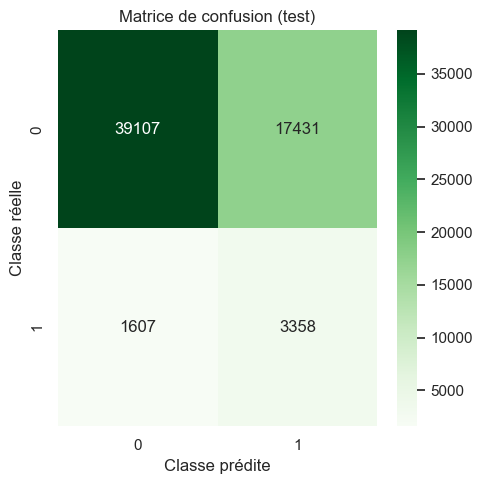

In [25]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")

plt.title("Matrice de confusion (test)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.tight_layout()
plt.show()

## DummyClassifier

In [26]:
def dummy_classifier(X_train, y_train, X_test, y_test, cv=5):
    
    dummy = DummyClassifier(strategy="most_frequent")

    start_time = time.time()
    y_pred_cv = cross_val_predict(dummy, X_train, y_train, cv=cv, n_jobs=-1)
    end_time = time.time()
    train_time = end_time - start_time

    dummy.fit(X_train, y_train)
    y_pred_test = dummy.predict(X_test)

    try:
        y_proba_test = dummy.predict_proba(X_test)[:, 1]
        auc_test = roc_auc_score(y_test, y_proba_test)
    except:
        auc_test = None
        
    accuracy_test = accuracy_score(y_test, y_pred_test)

    cost_cv = custom_cost_function(y_train, y_pred_cv,
                                  cost_false_positive=1,
                                  cost_false_negative=10)

    cost_test = custom_cost_function(y_test, y_pred_test,
                                    cost_false_positive=1,
                                    cost_false_negative=10)

    row = {
        "Model" : "DummyClassifier",
        "Hyperparams" : f"cross_val_predict(cv={cv})",
        "Cost_cv" : best_cost_cv,
        "Cost_test" : cost_test,
        "Accuracy_test" : accuracy_test,
        "AUC_test" : auc_test,
        "Training_time" : train_time,
        "Cost_fp" : 1,
        "Cost_fn" : 10,
        "Experiment_name" : "DummyClassifier (1:10)"
    }
        

    df_dummy = pd.DataFrame([row])

    return df_dummy

In [27]:
df_dummy = dummy_classifier(X_train, y_train, X_test, y_test, cv=5)
df_dummy

,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,DummyClassifier,cross_val_predict(cv=5),26992.4,49650,0.919272,0.5,1.932427,1,10,DummyClassifier (1:10)


### Matrice de confusion

In [28]:
cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
print(cm)

[[39107 17431]
 [ 1607  3358]]


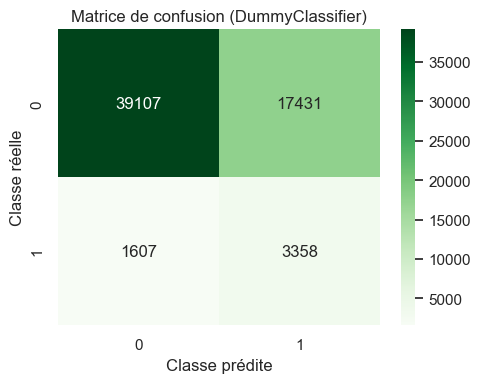

In [29]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")

plt.title("Matrice de confusion (DummyClassifier)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.tight_layout()
plt.show()

## RandomForestClassifier

In [30]:
param_grid_rf = {
    "n_estimators": [50, 100],
    "max_depth": [1, 5, 10],
    "min_samples_split": [2, 3]
}

In [31]:
def train_random_forest(X_train, y_train, param_grid_rf, cost_scorer):
    random_forest_classifier = RandomForestClassifier(class_weight="balanced", random_state=42)

    grid_search_rf = GridSearchCV(
    estimator=random_forest_classifier,
    param_grid=param_grid_rf,
    scoring=cost_scorer,
    cv=5,
    n_jobs=-1
    )

    start_time = time.time()
    grid_search_rf.fit(X_train, y_train)
    end_time = time.time()
    train_time_rf = end_time - start_time

    best_model_rf = grid_search_rf.best_estimator_
    best_params_rf = grid_search_rf.best_params_
    best_cost_cv_rf = -grid_search_rf.best_score_

    return best_model_rf, best_params_rf, best_cost_cv_rf, train_time_rf

In [32]:
best_model_rf, best_params_rf, best_cost_cv_rf, train_time_rf = train_random_forest(
    X_train, y_train, param_grid_rf, cost_scorer
)

In [33]:
df_rf = evaluate_and_log_model(
    best_model=best_model_rf,
    best_params=best_params_rf,
    best_cost_cv=best_cost_cv_rf,
    X_test=X_test,
    y_test=y_test,
    train_time=train_time_rf,
    experiment_name="Random Forest Classifier (1:10)",
    cost_fp=1,
    cost_fn=10,
    run_name="RF (1:10)"
)

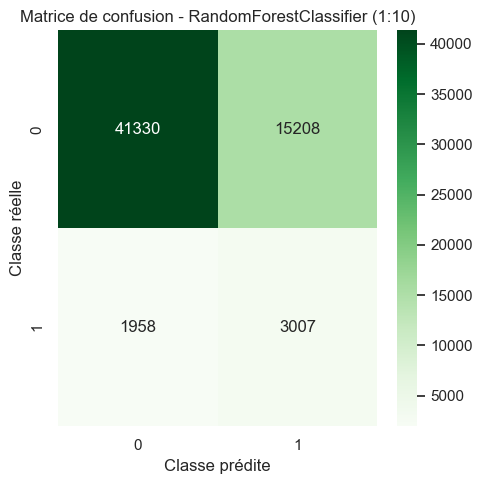

In [34]:
y_pred_test_rf = best_model_rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_test_rf, labels=[0, 1])
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

plt.figure(figsize=(5, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")

plt.title("Matrice de confusion - RandomForestClassifier (1:10)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.tight_layout()
plt.show()

In [35]:
df_results = pd.concat([
    df_dummy,
    df_reg_log,
    df_rf
], ignore_index=True)

df_results

,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,DummyClassifier,cross_val_predict(cv=5),26992.4,49650,0.919272,0.500000,1.932427,1,10,DummyClassifier (1:10)
1,LogisticRegression,{'C': 1},26992.4,33501,0.690454,0.748684,105.728099,1,10,Regression Logistique (1:10)
2,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}",28166.4,34788,0.720892,0.730433,525.559422,1,10,Random Forest Classifier (1:10)


### Feature importance

#### Globale

In [36]:
coeffs_rl = best_model.coef_.flatten()

coeffs_rl_df = pd.DataFrame({
    'feature' : feature_names,
    'coefficient' : coeffs,
    'abs_coefficient' : np.abs(coeffs)
}).sort_values(by='abs_coefficient', ascending=False)

coeffs_rl_df.head(50)

,feature,coefficient,abs_coefficient
7,AMT_GOODS_PRICE,-8.822388,8.822388
5,AMT_CREDIT,7.503174,7.503174
79,DEF_60_CNT_SOCIAL_CIRCLE,3.088403,3.088403
77,DEF_30_CNT_SOCIAL_CIRCLE,2.823975,2.823975
32,EXT_SOURCE_3,-2.433192,2.433192
81,FLAG_DOCUMENT_2,2.156624,2.156624
6,AMT_ANNUITY,2.085473,2.085473
31,EXT_SOURCE_2,-1.751002,1.751002
125,NAME_EDUCATION_TYPE_Academic degree,-1.460069,1.460069
123,NAME_INCOME_TYPE_Unemployed,1.362931,1.362931


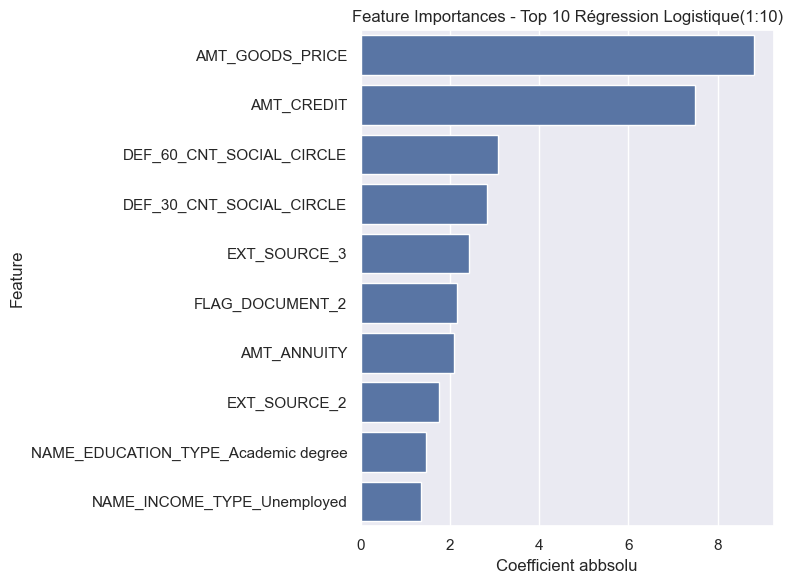

In [37]:
plt.figure(figsize=(8, 6))

sns.barplot(x="abs_coefficient", y="feature", data=coeffs_rl_df.head(10))
plt.title("Feature Importances - Top 10 Régression Logistique(1:10)")
plt.xlabel("Coefficient abbsolu")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

In [38]:
# Récupération des importances
importances = best_model_rf.feature_importances_

# Récupération des noms de colonnes
features_names = df.drop(columns=["TARGET"]).columns

# Construction du df
df_importances = pd.DataFrame({
    'feature' : feature_names,
    'importance': importances
})

# Tri par ordre décroissant
df_importances = df_importances.sort_values('importance', ascending=False)
df_importances.head(10)

,feature,importance
32,EXT_SOURCE_3,0.161608
31,EXT_SOURCE_2,0.158830
30,EXT_SOURCE_1,0.055398
10,DAYS_EMPLOYED,0.041900
9,DAYS_BIRTH,0.030800
7,AMT_GOODS_PRICE,0.024908
80,DAYS_LAST_PHONE_CHANGE,0.023112
5,AMT_CREDIT,0.020045
126,NAME_EDUCATION_TYPE_Higher education,0.017849
12,DAYS_ID_PUBLISH,0.017525


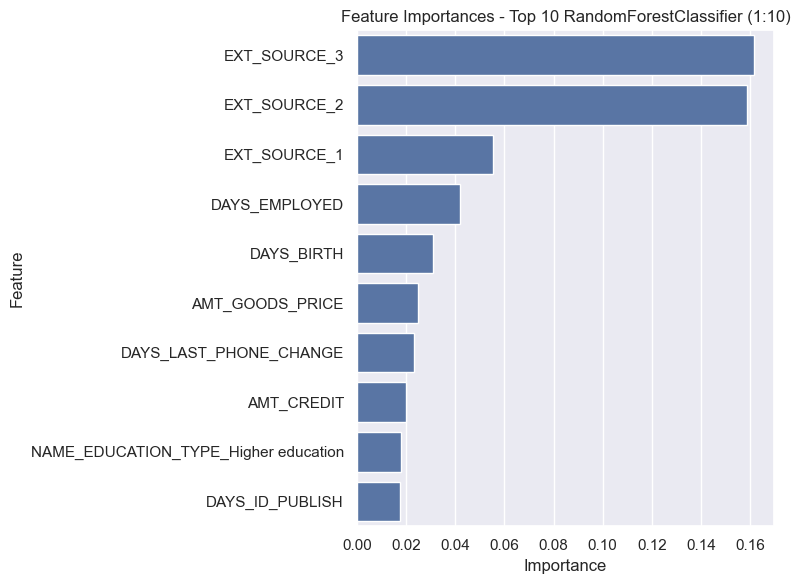

In [51]:
plt.figure(figsize=(8, 6))

sns.barplot(x="importance", y="feature", data=df_importances.head(10))
plt.title("Feature Importances - Top 10 RandomForestClassifier (1:10)")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

#### Locale

In [40]:
X_test_df = pd.DataFrame(X_test, columns=feature_names)
X_sample_df = X_test_df.sample(n=500, random_state=42)

In [41]:
X_test_df

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,0.0,1.0,1.0,0.052632,0.001127,0.181097,0.113338,0.161616,0.136490,0.339177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000550,0.079874,0.071411,0.068462,0.097483,0.576888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.000000,0.001050,0.059775,0.066409,0.046016,0.196267,0.941995,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.001389,0.232637,0.142752,0.207632,0.282797,0.121815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.000000,0.001320,0.069462,0.070376,0.059484,0.491595,0.563585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,0.0,0.0,1.0,0.000000,0.001166,0.197016,0.101702,0.169473,0.309272,0.756313,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
61499,0.0,1.0,1.0,0.000000,0.001320,0.314607,0.142506,0.315376,0.257000,0.580665,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
61500,0.0,1.0,1.0,0.052632,0.002858,0.048652,0.099228,0.046016,0.138276,0.331454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
61501,0.0,1.0,1.0,0.000000,0.002666,0.213483,0.172920,0.214366,0.129331,0.218433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


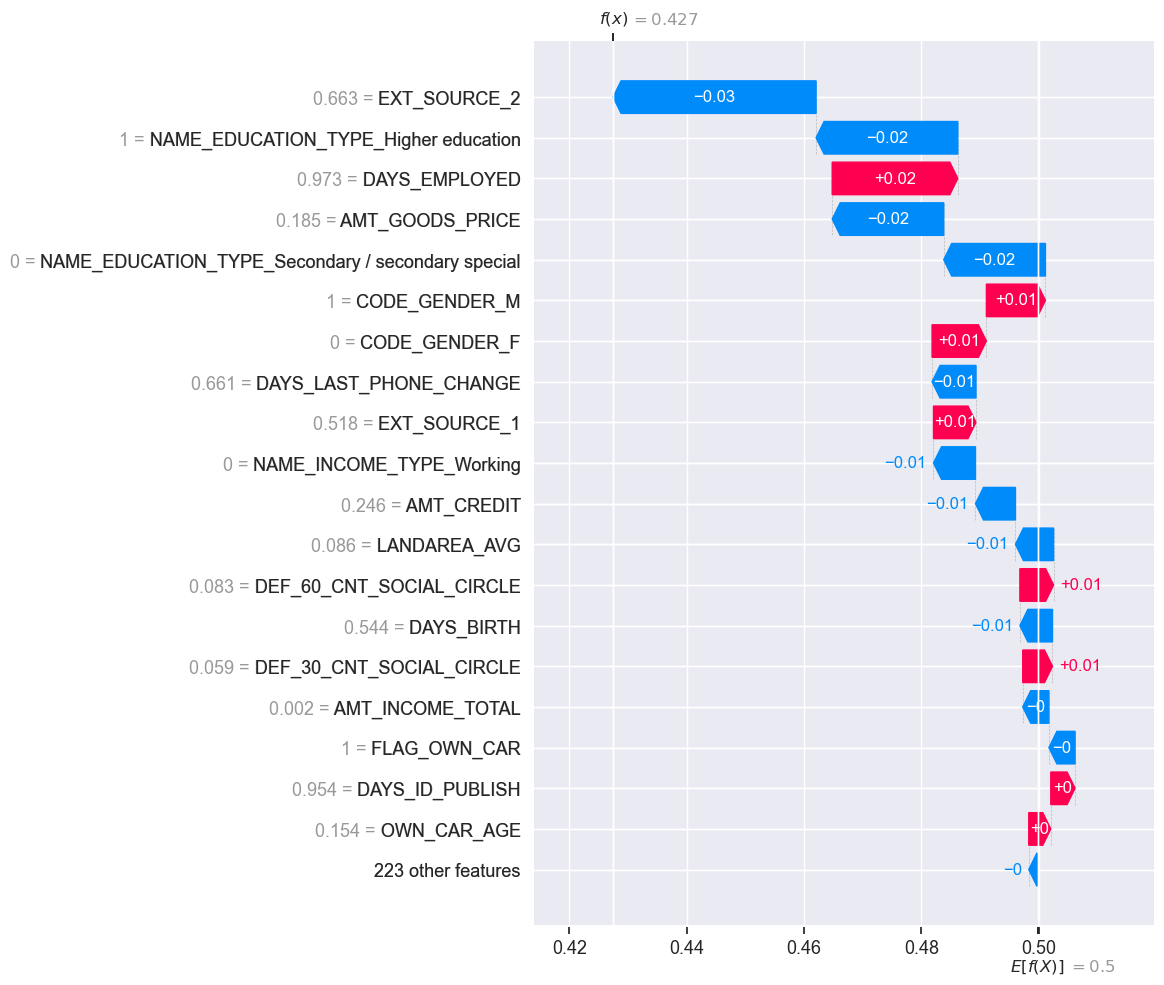

In [42]:
explainer = shap.TreeExplainer(best_model_rf)
shap_values = explainer.shap_values(X_sample_df)

# Choix d'un individu
i = 0

# Valeurs SHAP de la classe 1
shap_values_class_1 = shap_values[:, :, 1]

# Base value pour la classe 1 (valeur de base = expected_value)
base_value_class_1 = explainer.expected_value[1]

# Constrution de l'objet Explanation pour la classe 1 et l'individu 1
shap_values_i = shap_values_class_1[i, :]

explanation = shap.Explanation(
    values=shap_values_i, # Valeurs SHAP de l'individu 1
    base_values=base_value_class_1, # Valeur de base (moyenne log-odds ou prob)
    data=X_sample_df.iloc[i, :], # Les features de l'individu 1
    feature_names=X_sample_df.columns # Noms des colonnes pour le plot
)

# Génération du waterplot
shap.initjs()
shap.plots.waterfall(explanation, max_display=20)

Le but d'une feature importance locale est de montrer, pour un individu précis, comment chaque feature fait varier la prédiction par rapport à la valeur de base.

- Les barres bleues (négatives) réduisent la probabilité de classe 1
- Les barre roses (positives) l'augmentent
- Plus la variable est vers le haut au niveau du graphique, plus l'impact est fort pour cet individu

## LightGBM

In [44]:
def train_lightgbm(X_train, y_trani, param_grid_lgbm, cost_scorer):
    lightgbm_classifier = lgbm.LGBMClassifier(class_weight="balanced", random_state=42)
    grid_search_lgbm = GridSearchCV(
        estimator=lightgbm_classifier,
        param_grid=param_grid_lgbm,
        scoring=cost_scorer,
        cv=5,
        n_jobs=-1
    )

    start_time = time.time()
    grid_search_lgbm.fit(X_train, y_train)
    end_time = time.time()
    train_time_lgbm = end_time - start_time

    best_model_lgbm = grid_search_lgbm.best_estimator_
    best_params_lgbm = grid_search_lgbm.best_params_
    best_cost_cv_lgbm = -grid_search_lgbm.best_score_

    return best_model_lgbm, best_params_lgbm, best_cost_cv_lgbm, train_time_lgbm

In [45]:
param_grid_lgbm = {
    "n_estimators": [50, 100],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.01, 0.1],
}

best_model_lgbm, best_params_lgbm, best_cost_cv_lgbm, train_time_lgbm = train_lightgbm(X_train, y_train, param_grid_lgbm, cost_scorer)

print(f"Meilleurs hyperparamètres LightGBM : {best_params_lgbm}")
print(f"Meilleurs coût CV LightGBM : {best_cost_cv_lgbm}")
print(f"Temps d'entraînement LightGBM : {train_time_lgbm:.2f} secondes")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11437
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Meilleurs hyperparamètres LightGBM : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Meilleurs coût CV LightGBM : 26334.0
Temps d'entraînement LightGBM : 387.12 secondes


In [46]:
df_lgbm = evaluate_and_log_model(
    best_model=best_model_lgbm,
    best_params=best_params_lgbm,
    best_cost_cv=best_cost_cv_lgbm,
    X_test=X_test,
    y_test=y_test,
    train_time=train_time_lgbm,
    experiment_name="LightGBM Classifier (1:10)",
    cost_fp=1,
    cost_fn=10,
    run_name="LGBM (1:10)"
)

df_lgbm

,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,LGBMClassifier,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}",26334.0,32616,0.705868,0.759074,387.118072,1,10,LightGBM Classifier (1:10)


In [54]:
df_results_updated = pd.concat([
    df_dummy,
    df_reg_log,
    df_rf,
    df_lgbm
], ignore_index=True)

df_results_updated

,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,DummyClassifier,cross_val_predict(cv=5),26992.4,49650,0.919272,0.500000,1.932427,1,10,DummyClassifier (1:10)
1,LogisticRegression,{'C': 1},26992.4,33501,0.690454,0.748684,105.728099,1,10,Regression Logistique (1:10)
2,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}",28166.4,34788,0.720892,0.730433,525.559422,1,10,Random Forest Classifier (1:10)
3,LGBMClassifier,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}",26334.0,32616,0.705868,0.759074,387.118072,1,10,LightGBM Classifier (1:10)


### Matrice de confusion

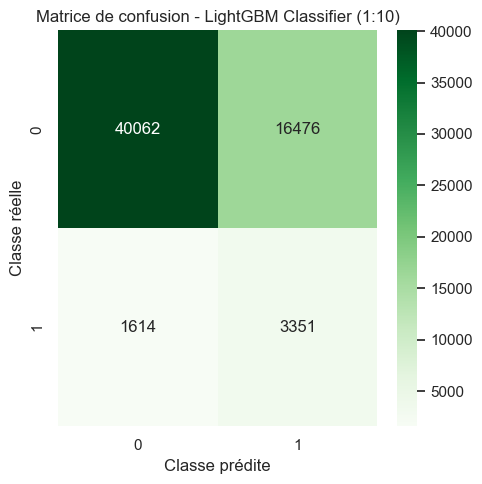

In [47]:
y_pred_test_lgbm = best_model_lgbm.predict(X_test)
cm_lgbm = confusion_matrix(y_test, y_pred_test_lgbm, labels=[0, 1])
tn_lgbm, fp_lgbm, fn_lgbm, tp_lgbm = cm_lgbm.ravel()

plt.figure(figsize=(5, 5))
sns.heatmap(cm_lgbm, annot=True, fmt="d", cmap="Greens")

plt.title("Matrice de confusion - LightGBM Classifier (1:10)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.tight_layout()
plt.show()

### Feature importance

#### Globale

In [48]:
importances_lgbm = best_model_lgbm.feature_importances_

df_importances_lgbm = pd.DataFrame({
    "feature" : feature_names,
    "importance" : importances_lgbm
})

df_importances_lgbm = df_importances_lgbm.sort_values("importance", ascending=False)
df_importances_lgbm.head(10)

,feature,importance
30,EXT_SOURCE_1,243
32,EXT_SOURCE_3,224
5,AMT_CREDIT,181
31,EXT_SOURCE_2,180
9,DAYS_BIRTH,166
6,AMT_ANNUITY,161
10,DAYS_EMPLOYED,140
7,AMT_GOODS_PRICE,133
12,DAYS_ID_PUBLISH,100
11,DAYS_REGISTRATION,80


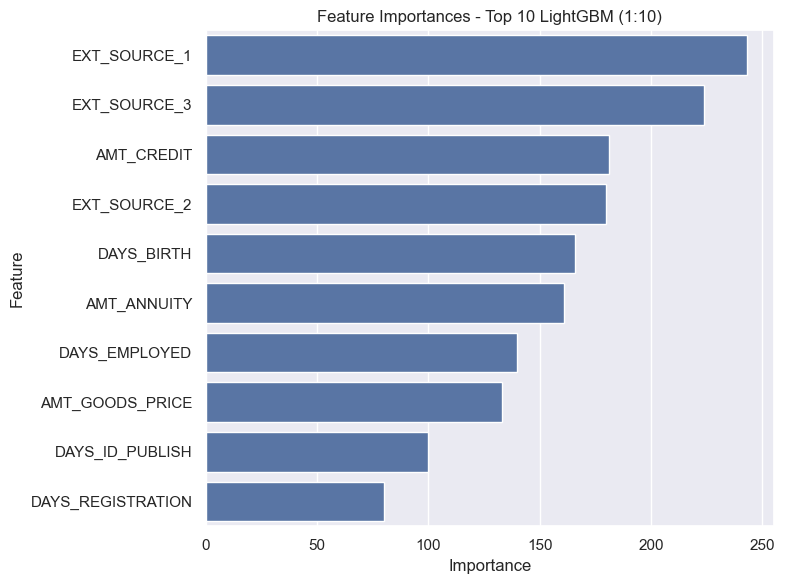

In [52]:
plt.figure(figsize=(8, 6))

sns.barplot(x="importance", y="feature", data=df_importances_lgbm.head(10))
plt.title("Feature Importances - Top 10 LightGBM (1:10)")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

#### Locale

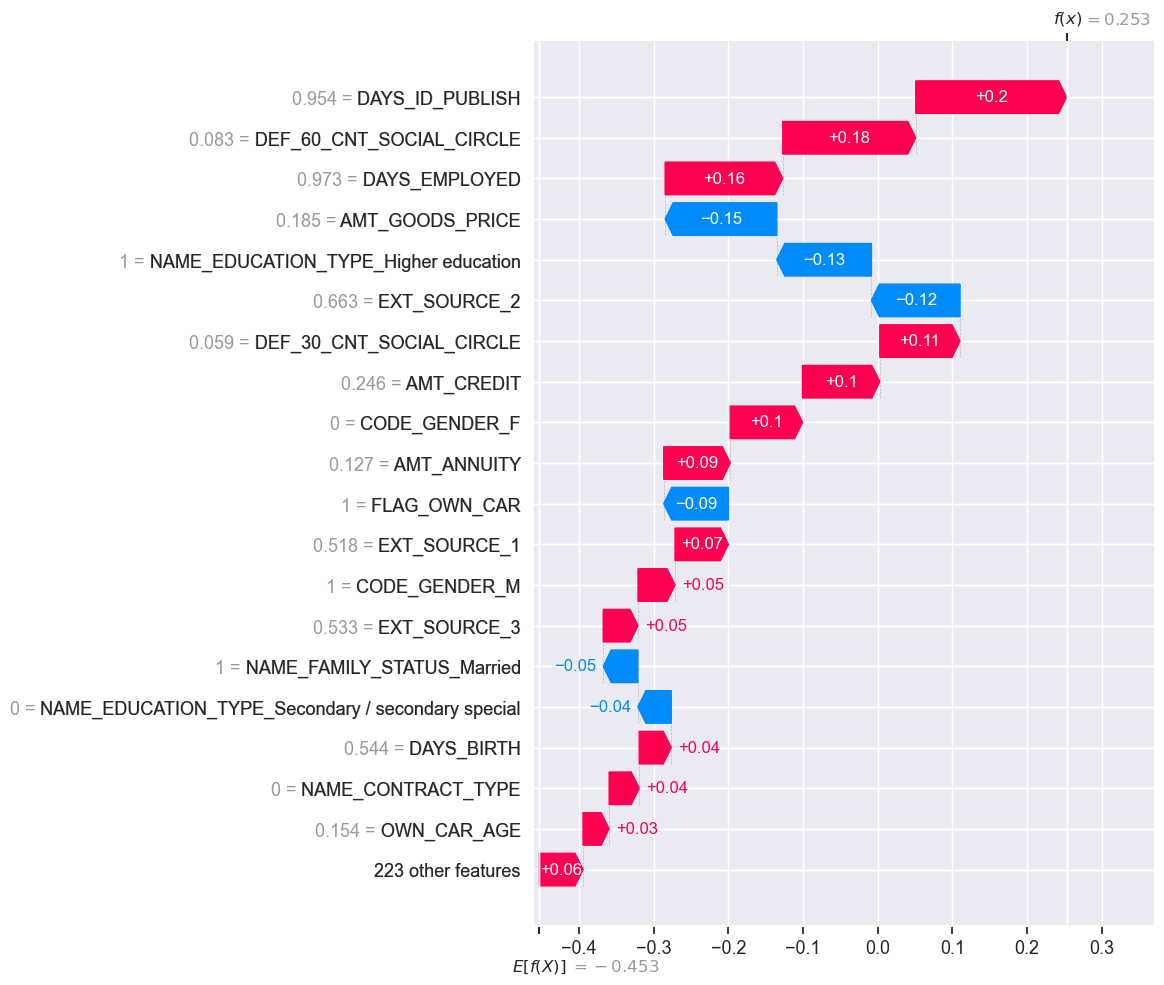

In [65]:
i = 0  # Choisir un individu

# Création d'un explainer SHAP
explainer_lgbm = shap.TreeExplainer(best_model_lgbm)

# Obtenir les valeurs SHAP pour un individu
individual_sample = X_sample_df.iloc[i:i+1, :]
shap_values = explainer_lgbm.shap_values(individual_sample)

explanation = shap.Explanation(
    values=shap_values[0],
    base_values=explainer_lgbm.expected_value,
    data=individual_sample.iloc[0].values,
    feature_names=individual_sample.columns
)

# Générer le waterfall plot
shap.initjs()
shap.plots.waterfall(explanation, max_display=20)